In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Import data
v0_df = pd.read_csv('../python_etl_processing/v0_df.csv')

In [3]:
# Create 'serious flag' for outcome - if an accident was fatal or had a serious injury
v0_df['serious_fl'] = v0_df.apply(lambda row: 1 if row['crash_fatal_fl'] == 1 or row['sus_serious_injry_cnt'] == 1 else 0, axis=1)

In [4]:
# Separate out date column
v0_df['year'] = pd.DatetimeIndex(v0_df['crash_date']).year
v0_df['month'] = pd.DatetimeIndex(v0_df['crash_date']).month
v0_df['day'] = pd.DatetimeIndex(v0_df['crash_date']).day
v0_df['crash_time'] = pd.to_datetime(v0_df['crash_time'])
v0_df['hour'] = pd.DatetimeIndex(v0_df['crash_time']).hour

In [5]:
# Import population csv
pop_df = pd.read_csv('../python_etl_processing/austin_pop.csv')

In [7]:
merged_df = v0_df.merge(pop_df, left_on="year", right_on="Year", how="left")
merged_df = merged_df.drop(columns="Year")
merged_df['year_month'] = merged_df['year'].astype(str) + merged_df['month'].astype(str)
merged_df.head()

,crash_id,crash_fatal_fl,crash_date,crash_time,crash_speed_limit,road_constr_zone_fl,latitude,longitude,crash_sev_id,sus_serious_injry_cnt,...,other_death_count,other_serious_injury_count,serious_fl,year,month,day,hour,Population,Growth Rate,year_month
0,"12,992,764",0,2012-11-06,2022-10-27 04:51:00,65.0,0.0,30.377406,-97.734442,3,0,...,0,0,0,2012,11,6,4,1495000,0.0425,201211
1,"12,979,184",0,2012-10-27,2022-10-27 05:01:00,0.0,0.0,30.421736,-97.665935,0,0,...,0,0,0,2012,10,27,5,1495000,0.0425,201210
2,"12,963,865",0,2012-10-22,2022-10-27 12:42:00,30.0,0.0,30.438155,-97.785708,3,0,...,0,0,0,2012,10,22,12,1495000,0.0425,201210
3,"12,979,325",0,2012-10-29,2022-10-27 03:00:00,25.0,0.0,30.205650,-97.854830,5,0,...,0,0,0,2012,10,29,3,1495000,0.0425,201210
4,"12,979,569",0,2012-10-18,2022-10-27 02:04:00,65.0,0.0,30.417802,-97.672780,2,0,...,0,0,0,2012,10,18,2,1495000,0.0425,201210


In [9]:
plot_columns = ['year_month', 'serious_fl']
plot_df = merged_df[plot_columns]
plot_df = plot_df.groupby('year_month').sum()
plot_df

,serious_fl
year_month,
201210,20
201211,39
201212,37
20131,41
201310,42
...,...
20225,49
20226,42
20227,47


<AxesSubplot:xlabel='year_month'>

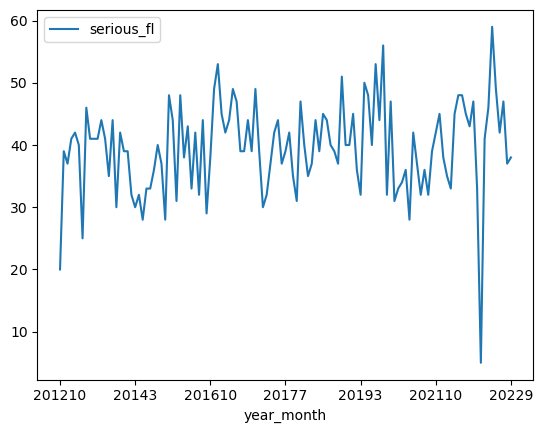

In [10]:
plot_df.plot()